In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import sqlite3
from scipy.optimize import curve_fit
from matplotlib.backends import backend_pdf

In [2]:
# SUPPORT FUNCTIONS TO CONVERT CHANNEL ID TO BOARD/PMT ID
# using hardware database inside icarus_data

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db", table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def get_channel_board(db, ch):
    
    board = db.loc[db['channel_id']==ch].digitizer_label.values[0]
    return board

In [3]:
# load data from all files for calibrations
def loadfiles(rundb, basepath="../"):
    
    data = {}
    for offset, run in rundb.items():
        file = basepath + run + "/measChannelBaselines_run" + run + ".csv"
        df = pd.read_csv(file, sep=',')
        data[offset] = df
    return data

In [4]:
# checks if baselines is stable at the beginning of each run, for each channel, within expected fluctuations
# necessary to make sure it is okay to use the mean computed on the first events
# n: number of events
# eps: acceptable fluctuations

def check_baseline_stability(geodb, rundb, data, n=20, eps=10):
    
    issues = {}
    
    # for each run
    for offset, run in rundb.items():
    
        timestamps = data[offset]["timestamp"].to_numpy()
        time = [datetime.fromtimestamp(t).strftime('%H:%M') for t in timestamps]
        fig = plt.figure()
        c = []
        
        #for each channel
        for ch in range(360):
            
            col = "baseline_ch" + str(ch)
            label_name = "Ch " + str(ch)
            baselines = data[offset][col].head(n).to_numpy()
            
            #check fluctuations
            if np.std(baselines) > eps:
                print("Warning: Run " + run + ", Ch " + str(ch) + ", board " + get_channel_board(geodb,ch) + ": instable baseline!")
                plt.plot(time,data[offset][col],label=label_name)
                c.append(ch)
        
        if fig.get_axes():
            plt.title(run)
            plt.xlabel("Time")
            plt.ylabel("Baseline [ADC]")
            plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
            plt.tight_layout()
            plt.grid()
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            issues[offset] = c
            
    return issues

In [5]:
# checks stability of using the median to compute the baseline at start
# only for channels that have shown to be instable!
# n: number of events

def check_median_stability(issues, rundb, data, n=20):
    
    for offset in issues.keys():
        
        run = rundb[offset]
        channels = issues[offset]
        print("Run " + run + ", pedestal " + str(offset) + ": " + str(len(channels)) + " channels")
        fig = plt.figure(figsize=(18,40))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        i = 0
        for ch in channels:
            
            col = "baseline_ch" + str(ch)
            baselines = data[offset][col].head(n).to_numpy()
            median = np.median(baselines)
            i = i+1
            ax = plt.subplot(len(channels),4,i)
            ax.hist(baselines, bins=50, range=(np.amin(baselines)-10,np.amax(baselines)+10), histtype='bar', lw=2, label="Mean: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.std(baselines)))
            ax.axvline(x=median, color="red", linestyle='dotted')
            ax.legend()
            ax.set_title(col)
        
        #fig.supxlabel("Baseline [ADC]",fontsize=16)
        plt.show()

In [6]:
def get_channel_data(ch, data, n=20, minerr=20.0):
    
    bs = []
    err = []
    col = "baseline_ch" + str(ch)
    for offset, df in data.items():
        baselines = df[col].head(n).to_numpy()
        bs.append(np.median(baselines))
        rms = np.sqrt( np.square(np.subtract(baselines,np.median(baselines))).mean())
        if rms < minerr: rms = minerr
        err.append(rms)
    
    return list(data.keys()), bs, err

def line(x,a,b):
    return a*x+b

In [7]:
def extrapolate_line(bs_target, a, err_a, b, err_b):
    
    dacnom = (bs_target-b)/a
    
    dxdb = -1./a
    dxda = (b-bs_target)/(a**2)
    
    edacnom = np.sqrt( (dxdb*err_b)**2 + (dxda*err_a)**2 )
    
    return dacnom, edacnom

In [8]:
def dofit( dcoffset, baseline, error_baseline, bs_target = 14747):
    
    a0 = (baseline[1]-baseline[0])/(dcoffset[1]-dcoffset[0])
    b0 = baseline[0]
    
    params, pcov = curve_fit(line, dcoffset, baseline, sigma=error_baseline, absolute_sigma=True, p0=(a0,b0))
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(dcoffset)-10, np.max(dcoffset)+10, 1000 )
    yint = line(xint, params[0], params[1])
    
    dacnom, edacnom= extrapolate_line( bs_target, params[0], stderr[0] , params[1], stderr[1] )
    
    return params, stderr, xint, yint, dacnom, edacnom

# Baseline calibration (all off)

Several runs at different DC offset values of the DAC, using the configuration with `CalibOnConfig = false`, `LockTempCalibration = true` and `AdcCalibration = false`

In [98]:
rundb = { 0:"9483", 3277:"9484", 6554:"9451", 9831:"9485", 13108:"9468", 32767:"9471"}
geodb = readSqlitedb()   

data = loadfiles(rundb, basepath="../runs/")

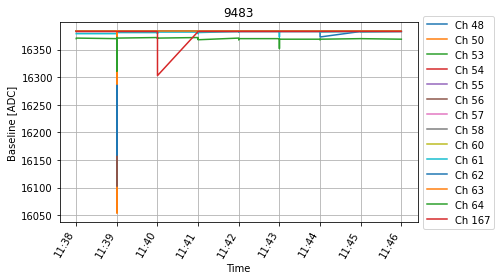

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [99]:
issues = check_baseline_stability(geodb, rundb, data, n=20)
#print(issues.items())

Run 9483, pedestal 0: 14 channels


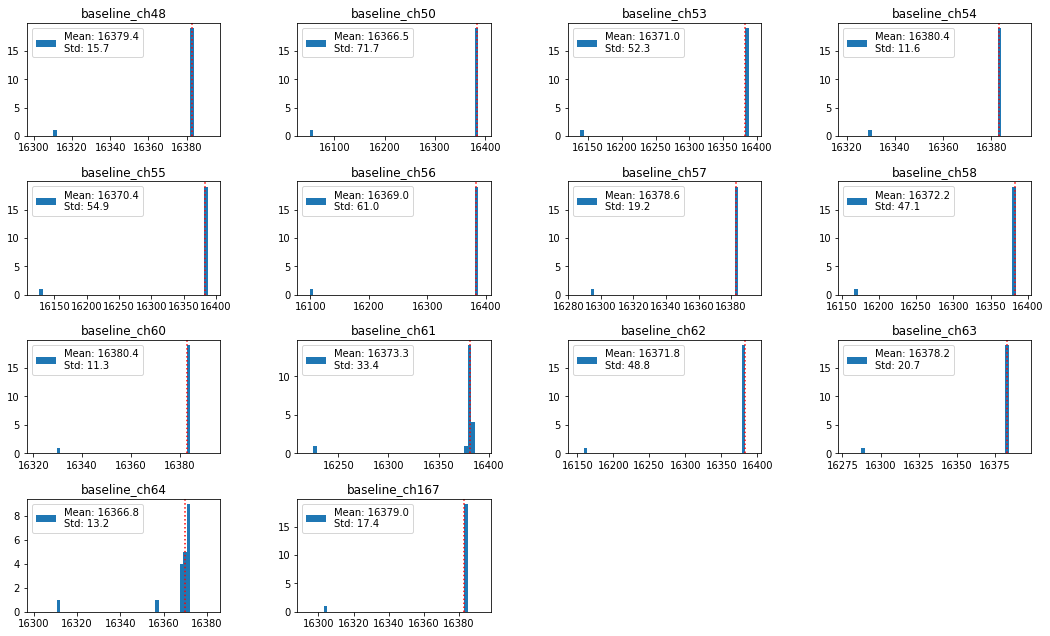

In [100]:
check_median_stability(issues, rundb, data, n=20)

### Plot one channel

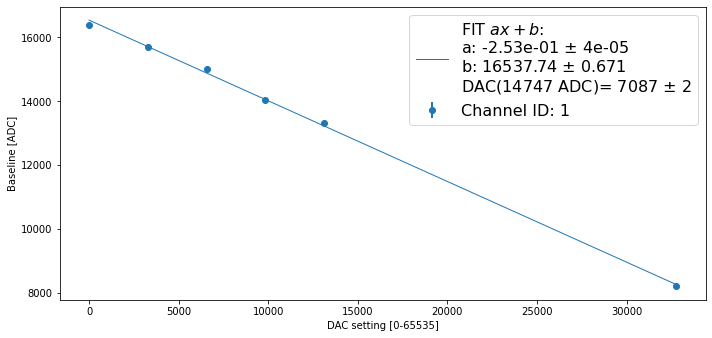

In [101]:
channel_id = 1
dac, bs, err = get_channel_data(channel_id, data, n=20)
target = 14747

fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.xlabel("DAC setting [0-65535]")
plt.ylabel("Baseline [ADC]")
plt.legend(fontsize=16)
    
fig.tight_layout()

### Plot everything

In [102]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_16Feb2023.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = get_channel_data(channel_id, data, n=20)
             
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_ylabel("DAC setting [0-65535]")
    ax.set_xlabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [103]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_16Feb2023.csv",sep=',')

## Produce output files

### Write requested DC offset

In [104]:
print("Writing DC offsets to equalize baselines at " + str(target))

path = "calibrations/DC_offsets_for_"+str(target)+"_16Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline,DC_offset\n"
ofile.write(header)

for channel_id in range(0,360):
    out = str(channel_id) + "," + str(target) + ","
    out += str(int(DAC_nominal[channel_id]))+"\n"
    ofile.write(out)
    
ofile.close()

Writing DC offsets to equalize baselines at 14747


In [105]:
current = 6554
print("Writing baselines corresponding to " + str(current))

path = "calibrations/baselines_at_"+str(current)+"_16Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline\n"
ofile.write(header)

for channel_id in range(0,360):
    
    a = calibDB[calibDB.channel_id==channel_id].p0.values[0]
    b = calibDB[calibDB.channel_id==channel_id].p1.values[0]
    bs = line(current,a,b)
    
    out = str(channel_id) + "," + str(int(bs))+"\n"
    ofile.write(out)
    
ofile.close()

Writing baselines corresponding to 6554


# Baseline calibration (standard runs)
Several runs at different DC offset values of the DAC, using the configuration with `CalibOnConfig = true`, `LockTempCalibration = true` and `AdcCalibration = true` (using old DAQ code for which it is always enabled)

In [57]:
rundb = { 0:"9572", 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575", 32767:"9576"}
geodb = readSqlitedb()   

data = loadfiles(rundb, basepath="../runs/")

In [58]:
issues = check_baseline_stability(geodb, rundb, data, n=20)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [59]:
check_median_stability(issues, rundb, data, n=20)

### Plot one channel

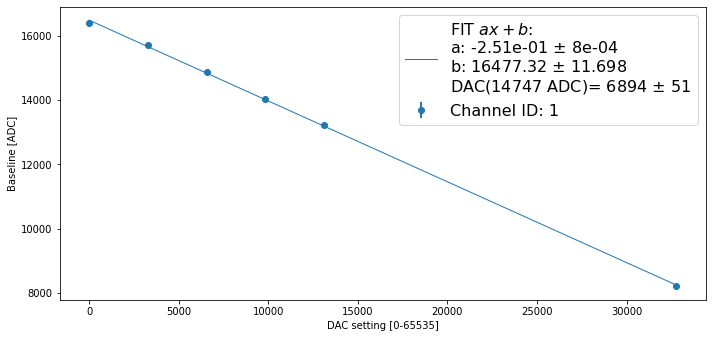

In [60]:
channel_id = 1
dac, bs, err = get_channel_data(channel_id, data, n=20, minerr=20.0)
target = 14747

fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.xlabel("DAC setting [0-65535]")
plt.ylabel("Baseline [ADC]")
plt.legend(fontsize=16)
    
fig.tight_layout()

### Plot everything

In [110]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_22Feb2023.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = get_channel_data(channel_id, data, n=20)
             
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_ylabel("DAC setting [0-65535]")
    ax.set_xlabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [111]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_22Feb2023.csv",sep=',')

### Write requested DC offset

In [112]:
print("Writing DC offsets to equalize baselines at " + str(target))

path = "calibrations/DC_offsets_for_"+str(target)+"_22Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline,DC_offset\n"
ofile.write(header)

for channel_id in range(0,360):
    out = str(channel_id) + "," + str(target) + ","
    out += str(int(DAC_nominal[channel_id]))+"\n"
    ofile.write(out)
    
ofile.close()

Writing DC offsets to equalize baselines at 14747


In [113]:
current = 6554
print("Writing baselines corresponding to " + str(current))

path = "calibrations/baselines_at_"+str(current)+"_22Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline\n"
ofile.write(header)

for channel_id in range(0,360):
    
    a = calibDB[calibDB.channel_id==channel_id].p0.values[0]
    b = calibDB[calibDB.channel_id==channel_id].p1.values[0]
    bs = line(current,a,b)
    
    out = str(channel_id) + "," + str(int(bs))+"\n"
    ofile.write(out)
    
ofile.close()

Writing baselines corresponding to 6554


## Second order calibration attempt (standard configuration)
Using same calibration runs, except the point at DAC = 32k + adding Run 9583 data

In [11]:
def get_channel_data_diff_pedestals(run, ch, dacpath, basepath="../runs/", n=20, minerr=20.0):
    
    # get baseline
    file = basepath + str(run) + "/measChannelBaselines_run" + str(run) + ".csv"
    df = pd.read_csv(file, sep=',')
    col = "baseline_ch" + str(ch)
    baselines = df[col].head(n).to_numpy()
    bs = np.median(baselines)
    err = np.sqrt( np.square(np.subtract(baselines,np.median(baselines))).mean())
    if err < minerr: err = minerr
    
    #get dac value
    df2 = pd.read_csv(dacpath, sep=",")
    dac = df2.loc[df2['channel_id']==ch, ['DC_offset']].values[0][0]
    
    return dac, bs, err

In [23]:
rundb = { 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575"} #0:"9572",  these are standard
addrun = 9583

geodb = readSqlitedb()   
data = loadfiles(rundb, basepath="../runs/")

### Plot single channel

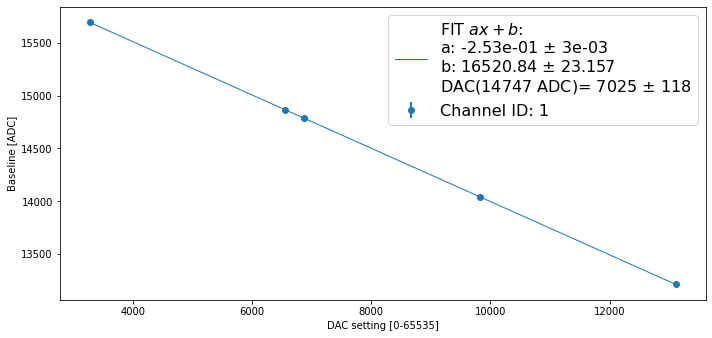

In [24]:
channel_id = 1
target = 14747

dac, bs, err = get_channel_data(channel_id, data, n=20)
n_dac, n_bs, n_err = get_channel_data_diff_pedestals(addrun, channel_id, 
                                                     dacpath="calibrations/DC_offsets_for_14747_22Feb2023.csv",
                                                     basepath = "../runs/",
                                                     n=20, minerr=20.)

dac.append(n_dac)
bs.append(n_bs)
err.append(n_err)

fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.xlabel("DAC setting [0-65535]")
plt.ylabel("Baseline [ADC]")
plt.legend(fontsize=16)
    
fig.tight_layout()

### Plot everything

In [17]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_2nd_23Feb2023.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = get_channel_data(channel_id, data, n=20)
    n_dac, n_bs, n_err = get_channel_data_diff_pedestals(addrun, channel_id, 
                                                     dacpath="calibrations/DC_offsets_for_14747_22Feb2023.csv",
                                                     basepath = "../runs/",
                                                     n=20, minerr=20.)
    dac.append(n_dac)
    bs.append(n_bs)
    ebs.append(n_err)
             
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_ylabel("DAC setting [0-65535]")
    ax.set_xlabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [125]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_2nd_23Feb2023.csv",sep=',')

### Writing outputs

In [126]:
print("Writing DC offsets to equalize baselines at " + str(target))

path = "calibrations/DC_offsets_for_"+str(target)+"_2nd_23Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline,DC_offset\n"
ofile.write(header)

for channel_id in range(0,360):
    out = str(channel_id) + "," + str(target) + ","
    out += str(int(DAC_nominal[channel_id]))+"\n"
    ofile.write(out)
    
ofile.close()

Writing DC offsets to equalize baselines at 14747


In [127]:
current = 6554
print("Writing baselines corresponding to " + str(current))

path = "calibrations/baselines_at_"+str(current)+"_2nd_23Feb2023.csv"
ofile = open(path,"w")
header = "channel_id,baseline\n"
ofile.write(header)

for channel_id in range(0,360):
    
    a = calibDB[calibDB.channel_id==channel_id].p0.values[0]
    b = calibDB[calibDB.channel_id==channel_id].p1.values[0]
    bs = line(current,a,b)
    
    out = str(channel_id) + "," + str(int(bs))+"\n"
    ofile.write(out)
    
ofile.close()

Writing baselines corresponding to 6554


## Third order calibration: fixing single channels

In [12]:
def plot_single_with_exceptions(rundb, addrun, ch, pdf, target=14747, num=20, perr=20):
    
    data = loadfiles(rundb, basepath="../runs/")
    dac, bs, err = get_channel_data(ch, data, n=num, minerr=perr)
    
    for run, path in addrun.items():
        n_dac, n_bs, n_err = get_channel_data_diff_pedestals(run, ch, 
                                                     dacpath=path,
                                                     basepath = "../runs/",
                                                     n=num, minerr=perr)
        dac.append(n_dac)
        bs.append(n_bs)
        err.append(n_err)
        
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
    out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
          
    r = bs - line(np.array(dac),p[0],p[1])
    chisq = np.sum((r / perr) ** 2)
    print( "Channel " + str(ch) + ": " + str(chisq))
        
    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    plt.xlabel("DAC setting [0-65535]")
    plt.ylabel("Baseline [ADC]")
    plt.legend(fontsize=16)
    
    fig.tight_layout()
    #pdf.savefig( fig )
    #plt.close()

    return dacnom, edacnom, p, ep

In [15]:
rundb = {  3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575" } #0:"9572", 32767:"9576"
addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }

geodb = readSqlitedb()

In [16]:
list_channels = [ 11, 13, 19, 45, 58, 60, 110, 140, 145, 157, 172, 262, 344]

Channel 11: 27.11879958843336
Channel 13: 0.019945918278073755
Channel 19: 0.06296671701476945
Channel 45: 8.637416417071403
Channel 58: 0.0020173548996111957
Channel 60: 0.004574207645280399
Channel 110: 0.05485585102158019
Channel 140: 10.400828072285535
Channel 145: 15.00799279576948
Channel 157: 0.10306779090286491
Channel 172: 28.190019267729525
Channel 262: 0.0712705666226855
Channel 344: 22.745382449293842


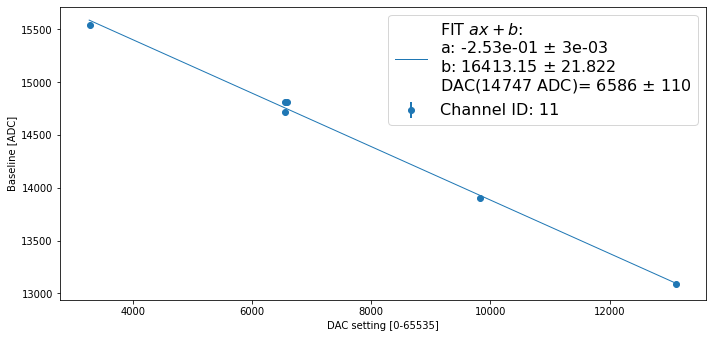

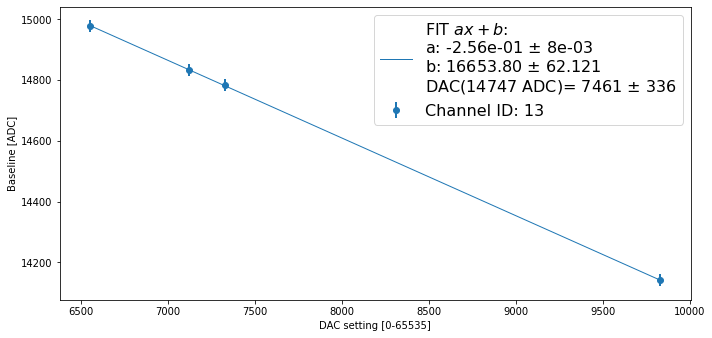

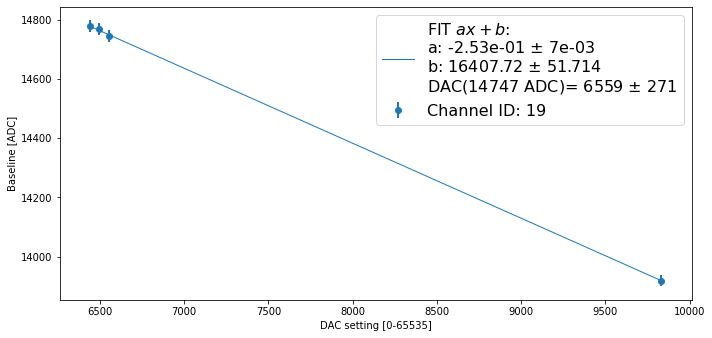

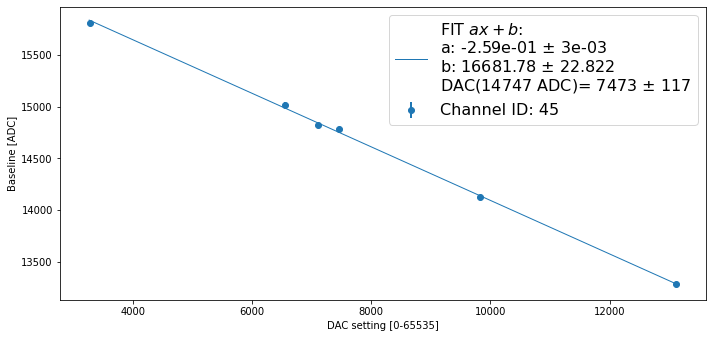

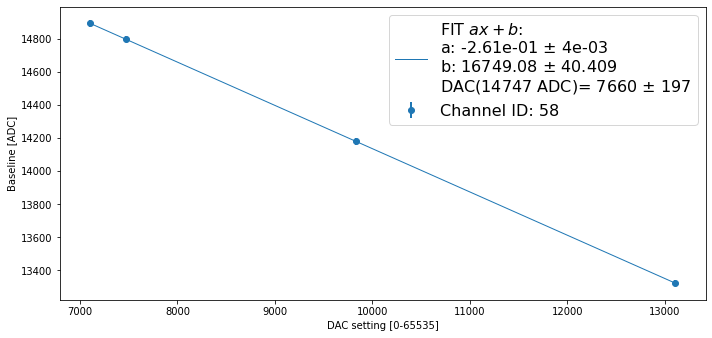

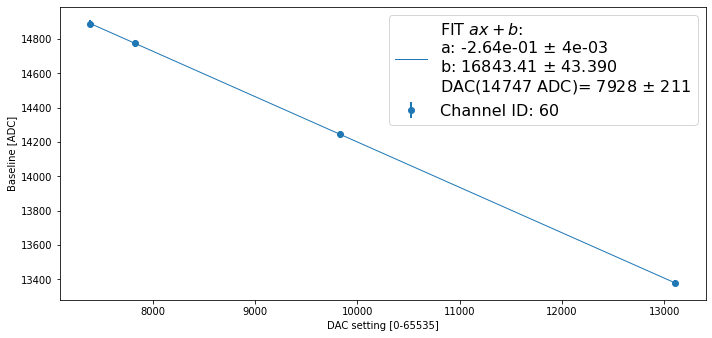

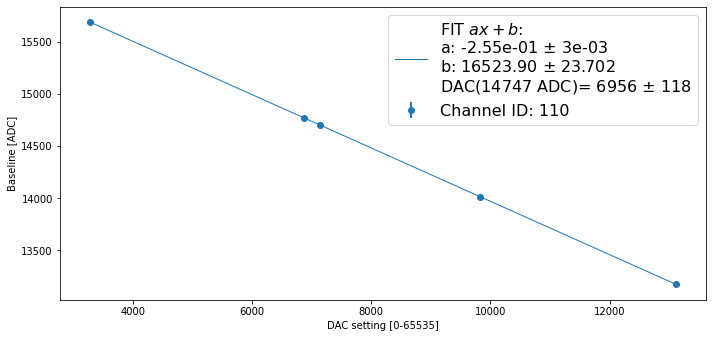

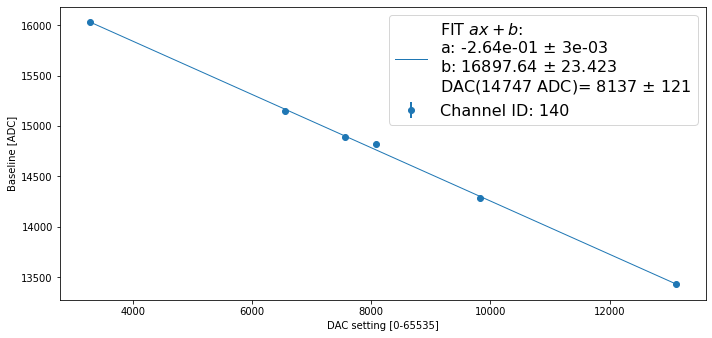

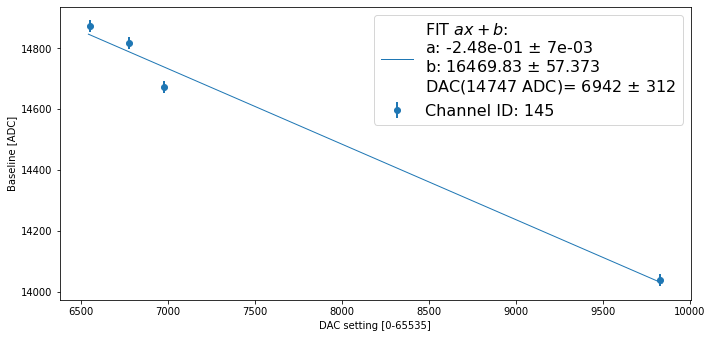

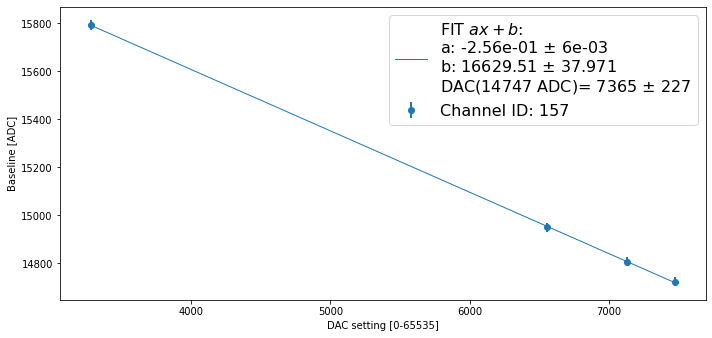

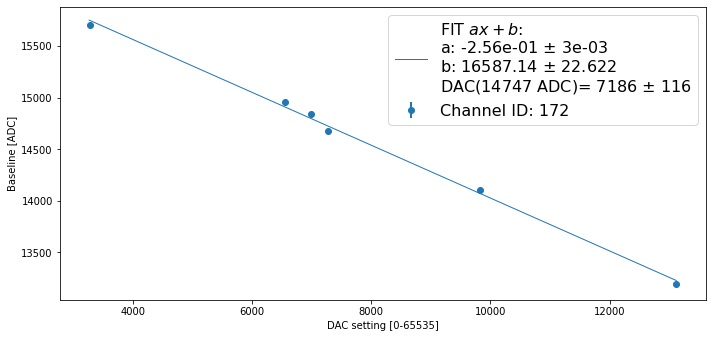

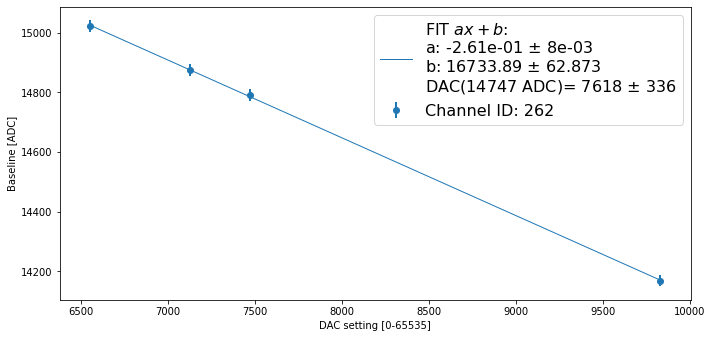

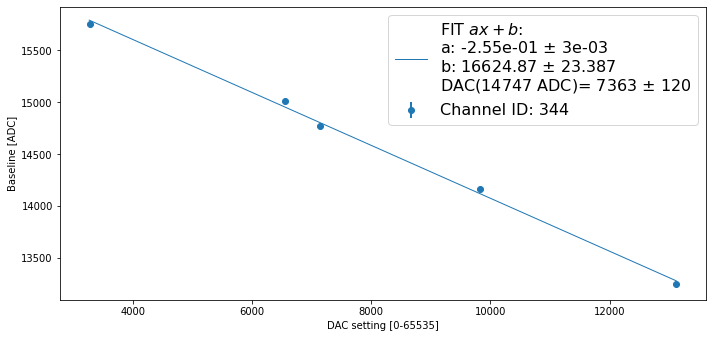

In [25]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_3rd_28Feb2023.pdf")

ttarget = 14747

calibration = []
DAC_nominal = []

for channel_id in list_channels:
    
    if channel_id == 11: ### DA LAVORARE
        rundb = {  3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575" }
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }

    elif channel_id == 13:
        rundb = {  6554:"9564", 9831:"9574" }
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 19:
        rundb = { 6554:"9564", 9831:"9574"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
     
    elif channel_id == 45: ### DA LAVORARE
        rundb = { 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 58:
        rundb = {   9831:"9574", 13108:"9575" }
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 60:
        rundb = {   9831:"9574", 13108:"9575" }
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 110:
        rundb = { 3277:"9573", 9831:"9574", 13108:"9575"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 140: ### DA LAVORARE
        rundb = { 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 145: ### DA LAVORARE
        rundb = {  6554:"9564", 9831:"9574" }
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 157:
        rundb = { 3277:"9573", 6554:"9564"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 172: ### DA LAVORARE
        rundb = { 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 262:
        rundb = { 6554:"9564", 9831:"9574"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv", 9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    elif channel_id == 344: ### DA LAVORARE
        rundb = { 3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575"}
        addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv"} #9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv" }
    
    d, ed, p, ep = plot_single_with_exceptions(rundb, addrun, channel_id, pdf, target=ttarget, num=20, perr=20)
    
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(d)

pdf.close()

In [18]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_3rd_28Feb2023.csv",sep=',')

In [19]:
p_off = pd.read_csv("calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv",sep=',')
deltas = [60.5, 36.0, 31.0, 34.0, 51.0, 28.0, -42.0, 71.5, -74.5, -24.0, -67.0, 43.0, -70.0 ]

i = 0
for ch in list_channels:
    print( "ch_"+str(ch) + " OLD " + str(p_off.loc[p_off['channel_id']==ch, ['DC_offset']].values[0][0]) + ", NEW " + str(int(DAC_nominal[i])) + " -> " + str(int(DAC_nominal[i]) - p_off.loc[p_off['channel_id']==ch, ['DC_offset']].values[0][0]) + " vs baseline " + str(deltas[i]))
    i+=1

ch_11 OLD 6583, NEW 6586 -> 3 vs baseline 60.5
ch_13 OLD 7328, NEW 7461 -> 133 vs baseline 36.0
ch_19 OLD 6442, NEW 6559 -> 117 vs baseline 31.0
ch_45 OLD 7464, NEW 7473 -> 9 vs baseline 34.0
ch_58 OLD 7467, NEW 7660 -> 193 vs baseline 51.0
ch_60 OLD 7823, NEW 7928 -> 105 vs baseline 28.0
ch_110 OLD 7135, NEW 6956 -> -179 vs baseline -42.0
ch_140 OLD 8083, NEW 8137 -> 54 vs baseline 71.5
ch_145 OLD 6980, NEW 6942 -> -38 vs baseline -74.5
ch_157 OLD 7475, NEW 7365 -> -110 vs baseline -24.0
ch_172 OLD 7282, NEW 7186 -> -96 vs baseline -67.0
ch_262 OLD 7471, NEW 7618 -> 147 vs baseline 43.0
ch_344 OLD 7508, NEW 7341 -> -167 vs baseline -70.0


### Writing outputs

In [44]:
print("Writing DC offsets to equalize baselines at " + str(target))
path = "calibrations/DC_offsets_for_"+str(target)+"_3rd_28Feb2023.csv"

i=0
for ch in list_channels:

    if ch == 11:
        DAC_nominal[i] = 6700
    
    p_off.at[ch,"DC_offset"] = int(DAC_nominal[i])
    print(ch, int(DAC_nominal[i]))
    i+=1
    
p_off.to_csv(path,sep=',')

Writing DC offsets to equalize baselines at 14747
11 6700
13 7461
19 6559
45 7473
58 7660
60 7928
110 6956
140 8137
145 6942
157 7365
172 7186
262 7618
344 7341


## Fourth calibration: final single-channel adjustments

In [27]:
rundb = {  }#3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575" } #0:"9572", 32767:"9576"
addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv",
           9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv",
           9591:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9592:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9593:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9594:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
         }

geodb = readSqlitedb()
list_channels = [ 11, 145, 172, 268, 270, 344]

Channel 11: 30.128562920678164
Channel 145: 16.090828431215314
Channel 172: 16.035471384171004
Channel 268: 1.5125
Channel 270: 2.9829999999999997
Channel 344: 0.02875287080456994


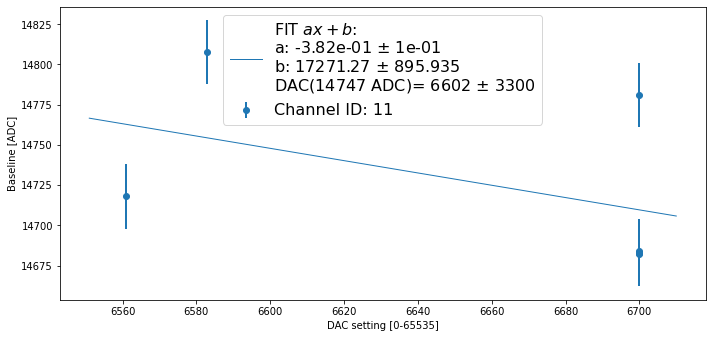

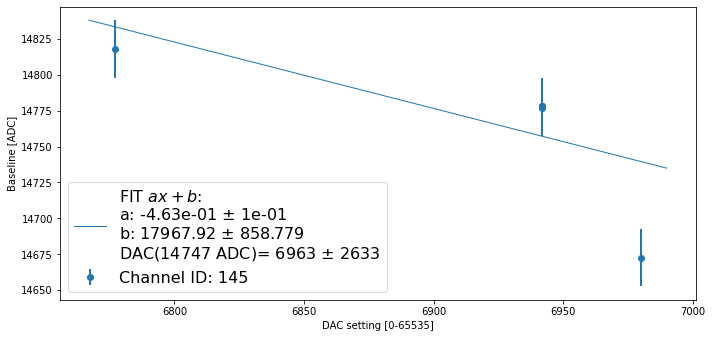

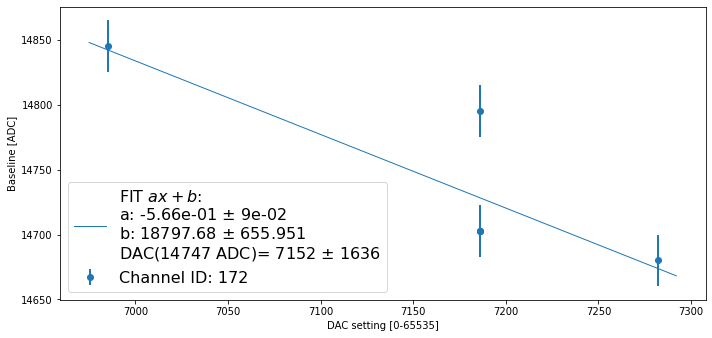

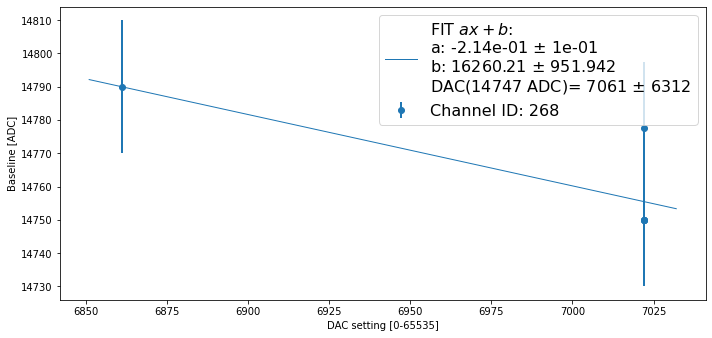

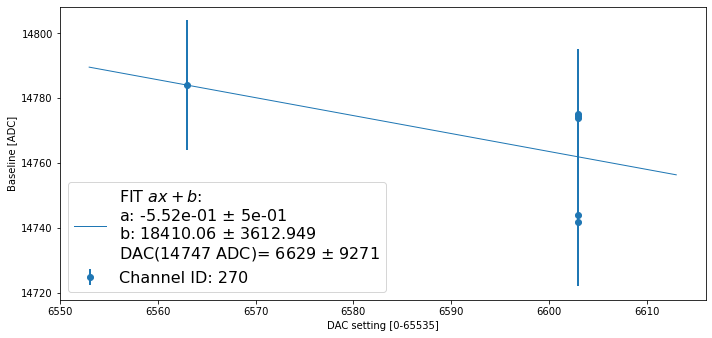

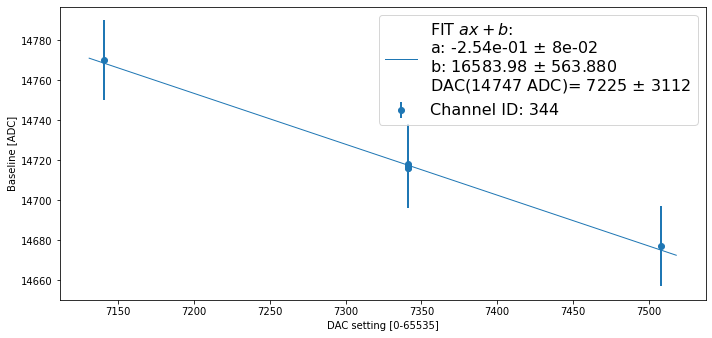

In [28]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_4th_28Feb2023.pdf")

ttarget = 14747

calibration = []
DAC_nominal = []

for channel_id in list_channels:
    
    d, ed, p, ep = plot_single_with_exceptions(rundb, addrun, channel_id, pdf, target=ttarget, num=20, perr=20)
    
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(d)

pdf.close()

In [29]:
#current values
p_off = pd.read_csv("calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",sep=',')

#get baseline deltas:
b_file = "../runs/9594/measChannelBaselines_run9594.csv"
b_latest = pd.read_csv(b_file, sep=',')

i = 0
for ch in list_channels:
    col = "baseline_ch" + str(ch)
    currbs = np.median(b_latest[col].head(20).to_numpy())
    print( "ch_"+str(ch) + " OLD " + str(p_off.loc[p_off['channel_id']==ch, ['DC_offset']].values[0][0]) + ", NEW " + str(int(DAC_nominal[i])) + " -> " + str(int(DAC_nominal[i]) - p_off.loc[p_off['channel_id']==ch, ['DC_offset']].values[0][0]) + " vs baseline " + str(currbs-ttarget))
    i+=1

ch_11 OLD 6700, NEW 6602 -> -98 vs baseline -63.0
ch_145 OLD 6942, NEW 6963 -> 21 vs baseline 31.0
ch_172 OLD 7186, NEW 7152 -> -34 vs baseline -44.0
ch_268 OLD 7022, NEW 7061 -> 39 vs baseline 30.5
ch_270 OLD 6603, NEW 6629 -> 26 vs baseline 28.0
ch_344 OLD 7341, NEW 7225 -> -116 vs baseline -29.0


Comments:
* ch11: it moved from +60 to -60, try to move it back (half the displacement made before > 120 DAC), so try going back to 6640. This way, if it continues to jump, it will be more towards positive deltas (which is better --> higher thr)
* ch145: correction seems good, small and may reduce a little bit the positive delta.
* ch172: increasing correction to make sure we truly reduce the negative delta... instead of 7152 move to 7140.
* ch268: reduce it a little bit, but not too much: 7040
* ch270: reduce it a little bit, but not too much: 6613
* ch344: correction from fit seems good

In [31]:
print("Writing DC offsets to equalize baselines at " + str(ttarget))
path = "calibrations/DC_offsets_for_"+str(ttarget)+"_4th_3Mar2023.csv"

i=0
for ch in list_channels:

    if ch == 11:
        DAC_nominal[i] = 6640
    
    if ch == 172:
        DAC_nominal[i] = 7140
        
    if ch == 268:
        DAC_nominal[i] = 7040
        
    if ch == 270:
        DAC_nominal[i] = 6613
    
    p_off.at[ch,"DC_offset"] = int(DAC_nominal[i])
    print(ch, int(DAC_nominal[i]))
    i+=1
    
p_off.to_csv(path,sep=',')

Writing DC offsets to equalize baselines at 14747
11 6640
145 6963
172 7140
268 7040
270 6613
344 7225


# Just checking

In [13]:
rundb = {  }#3277:"9573", 6554:"9564", 9831:"9574", 13108:"9575" } #0:"9572", 32767:"9576"
addrun = { 9583:"calibrations/DC_offsets_for_14747_22Feb2023.csv",
           9589:"calibrations/DC_offsets_for_14747_2nd_23Feb2023.csv",
           9591:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9592:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9593:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9594:"calibrations/DC_offsets_for_14747_3rd_28Feb2023.csv",
           9597:"calibrations/DC_offsets_for_14747_4th_3Mar2023.csv",
         }

geodb = readSqlitedb()
list_channels = [ 11, 145, 172, 268, 270, 340, 344]

Channel 11: 32.55766525455125
Channel 145: 26.126655343990294
Channel 172: 19.29858866737421
Channel 268: 1.5552795935773913
Channel 270: 3.4333636363635938
Channel 340: 14.8096875
Channel 344: 0.03242393857796812


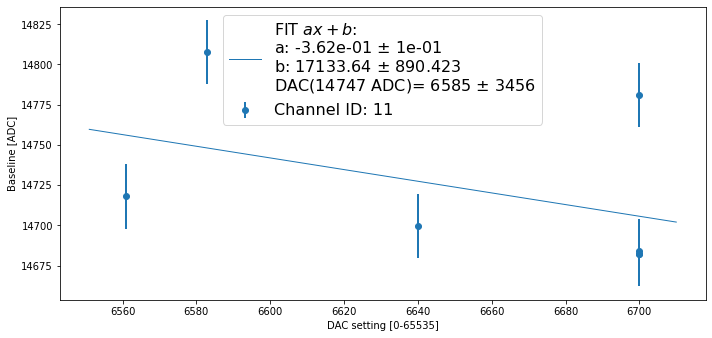

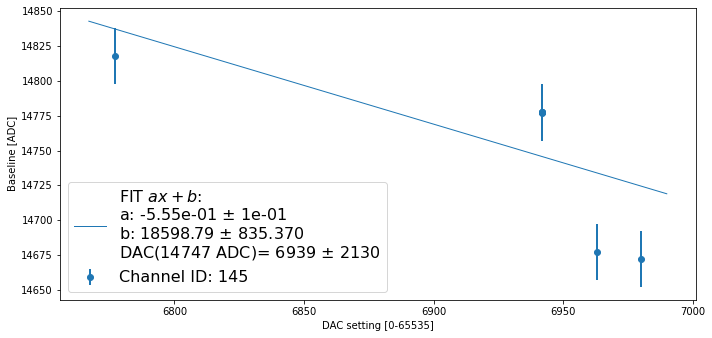

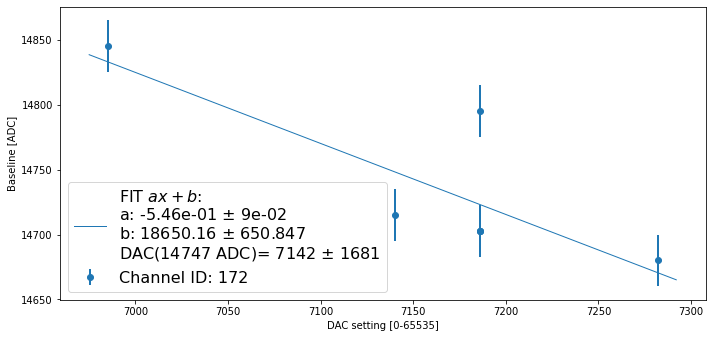

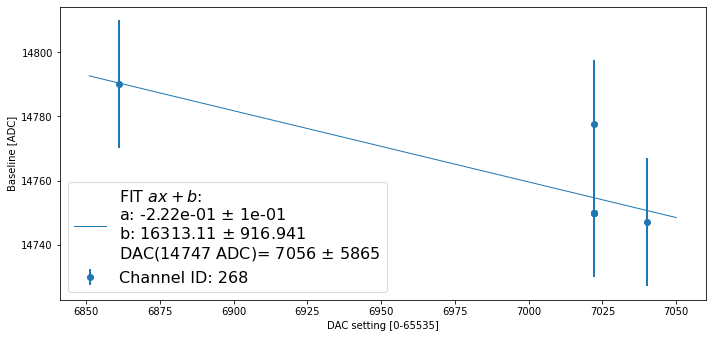

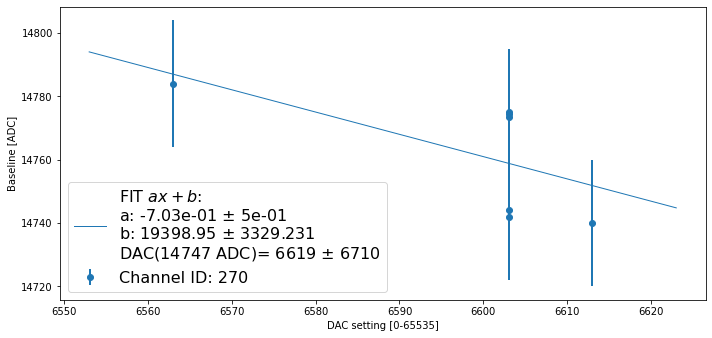

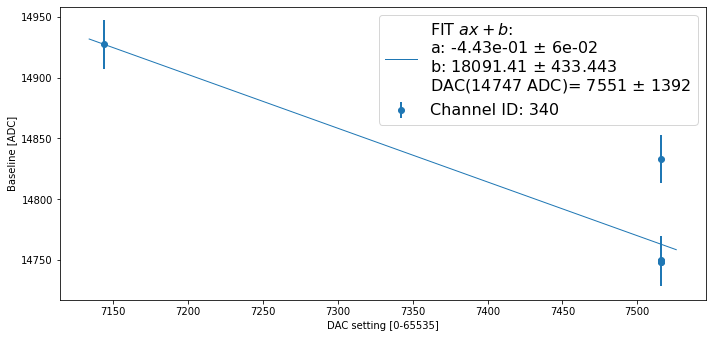

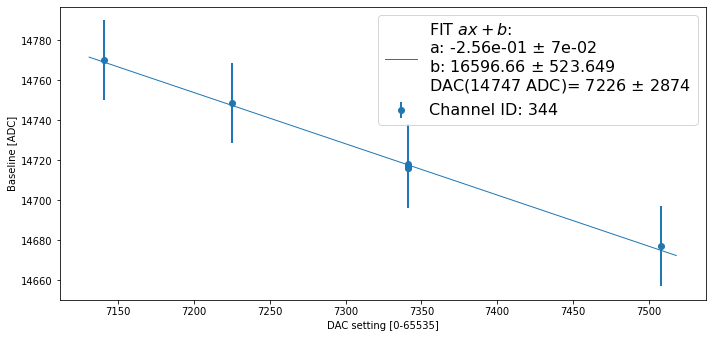

In [14]:
pdf = backend_pdf.PdfPages("calibrations/test.pdf")

ttarget = 14747

calibration = []
DAC_nominal = []

for channel_id in list_channels:
    
    d, ed, p, ep = plot_single_with_exceptions(rundb, addrun, channel_id, pdf, target=ttarget, num=20, perr=20)
    
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(d)

pdf.close()

In [ ]:
for ch in list_channels:
    